### Configuration initiale et importation des paquets

Dans cette section, nous importons plusieurs paquets essentiels pour notre analyse. Voici une explication de chaque paquet :

- `Plots` : Ce paquet est utilisé pour créer une grande variété de graphiques et de visualisations. Nous importons également `plot!` et `vline!` de `Plots` pour des fonctionnalités de tracé supplémentaires.
- `LinearAlgebra` : Ce paquet fournit une collection de fonctionnalités d'algèbre linéaire, telles que les opérations matricielles et les décompositions.
- `Optim` : Ce paquet est utilisé pour l'optimisation mathématique, offrant des algorithmes pour trouver le minimum ou le maximum de fonctions.
- `Statistics` : Ce paquet fournit des fonctions statistiques de base, telles que les calculs de moyenne, de variance et d'écart-type.
- `Distributions` : Ce paquet nous permet de travailler avec des distributions de probabilité, offrant des fonctions pour définir, échantillonner et manipuler différents types de distributions.
- `Random` : Ce paquet fournit des fonctionnalités pour la génération de nombres aléatoires, permettant la reproductibilité et le contrôle du hasard dans les simulations.

In [34]:
using Plots
import Plots: plot!, vline!
using LinearAlgebra
using Optim
using Statistics
using Distributions
using Random

### Définition de la structure `WienerProcess`

Dans cette section, nous définissons une structure mutable appelée `WienerProcess` pour représenter un processus de Wiener, également connu sous le nom de mouvement brownien. Voici une explication des composants de cette structure :

- `mu::T` : La dérive (moyenne) du processus, de type `T` (qui doit être un sous-type de `Number`).
- `sigma2::T` : La variance du processus, de type `T`.
- `timestep::T` : Le pas de temps entre chaque étape du processus, de type `T`.
- `values::Vector{T}` : Un vecteur pour stocker les valeurs du processus simulé, de type `T`.
- `steps::Int` : Le nombre d'étapes de temps dans le processus.
- `times::Vector{T}` : Un vecteur pour stocker les temps correspondants à chaque valeur du processus, de type `T`.

#### Constructeur

Le constructeur `WienerProcess{T}(mu::T, sigma2::T, timestep::T, steps::Int) where T<:Number` initialise le processus sans valeurs simulées. Voici comment il fonctionne :

- `mu`, `sigma2`, `timestep`, et `steps` sont passés en tant que paramètres.
- `values` est initialisé comme un vecteur non défini de type `T` et de longueur `steps + 1`.
- `times` est initialisé en utilisant la fonction `collect` pour créer une séquence de temps allant de `0` à `steps * timestep`, avec un pas de `timestep`.

En utilisant `new{T}`, nous créons une instance de `WienerProcess` avec les valeurs spécifiées.


In [35]:
mutable struct WienerProcess{T<:Number}
    mu::T
    sigma2::T
    timestep::T
    values::Vector{T}
    steps::Int
    times::Vector{T}

    # Constructeur pour initialiser le processus sans valeurs simulées
    function WienerProcess{T}(mu::T, sigma2::T, timestep::T, steps::Int) where T<:Number
        new{T}(mu, sigma2, timestep, Vector{T}(undef, steps + 1), steps, collect(0:timestep:steps * timestep))
    end
end

### Fonction de simulation du processus de Wiener

Dans cette section, nous définissons une fonction pour simuler le processus de Wiener, qui met à jour les valeurs du processus à chaque étape de temps. Voici une explication détaillée de la fonction `simulate!` :

#### Fonction `simulate!`

```julia
function simulate!(wp::WienerProcess)


In [36]:
# Fonction pour simuler le processus de Wiener
function simulate!(wp::WienerProcess)
    sqrt_sigma2 = sqrt(wp.sigma2)
    wp.values = [0.0]
    normal_dist = Normal(0, 1)  # Définir une distribution normale standard
    for t in 1:wp.steps
        dt = wp.timestep
        dW = sqrt_sigma2 * sqrt(dt) * rand(normal_dist)
        new_value = wp.values[end] + wp.mu * dt + dW
        push!(wp.values, new_value)
    end
end

simulate! (generic function with 2 methods)

### Méthode pour tracer le processus de Wiener

Dans cette section, nous définissons une fonction pour tracer le processus de Wiener et la droite de dérive \( \mu t \). `plot!` :

In [37]:
# Méthode pour tracer le processus de Wiener
function plot!(process::WienerProcess)
    # Tracer le processus de Wiener
    plot!(process.times, process.values, xlabel="Time", ylabel="Wiener Process", label="Wiener Process", 
    linestyle=:dash, markercolor=:blue)
    
    # Tracer la droite mu*t
    plot!(process.times, process.mu .* process.times, label="mu*t", linestyle=:dash)
end

plot! (generic function with 6 methods)

#### Exemple de simulation d'un processus de Wiener

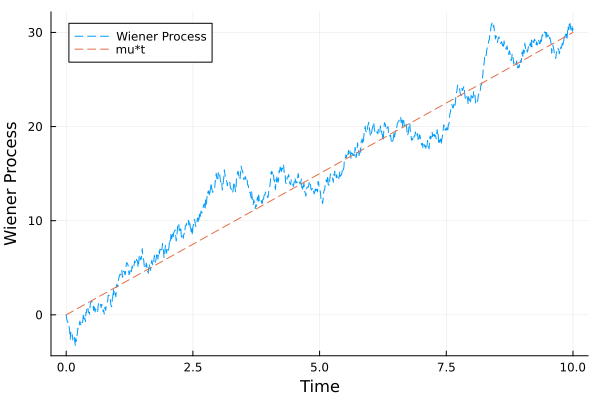

In [38]:
# Définir les paramètres du processus de Wiener
mu = 3.0
sigma2 = 16.0
timestep = 0.01
steps = 1000

# Créer une instance de WienerProcess
process = WienerProcess{Float64}(mu, sigma2, timestep, steps)

# Simuler le processus de Wiener
simulate!(process)

plot()
# Tracer le processus de Wiener simulé
plot!(process)

### Définition de la structure `WienerARD1`

Dans cette section, nous définissons une structure mutable appelée `WienerARD1` qui représente un processus de Wiener avec des interventions de maintenance à des temps spécifiques. Voici une explication des composants de cette structure :

#### Composants de `WienerARD1`

- `underlying_process::WienerProcess{Float64}` : Un processus de Wiener sous-jacent de type `Float64`.
- `rho::Float64` : Un paramètre de corrélation ou d'autocorrélation.
- `maintenance_times::Vector{Float64}` : Un vecteur contenant les temps de maintenance.
- `k::Int` : Le nombre de temps de maintenance.
- `values::Vector{Vector{Float64}}` : Un vecteur de vecteurs pour stocker les valeurs du processus après chaque intervalle de maintenance.
- `new_times::Vector{Vector{Float64}}` : Un vecteur de vecteurs pour stocker les nouveaux intervalles de temps jusqu'à chaque temps de maintenance.

#### Constructeur

Le constructeur `WienerARD1` initialise les paramètres du processus, simule le processus de Wiener sous-jacent, et divise les temps en intervalles définis par les temps de maintenance. 

In [39]:
mutable struct WienerARD1
    underlying_process::WienerProcess{Float64}
    rho::Float64
    maintenance_times::Vector{Float64}
    k::Int
    values::Vector{Vector{Float64}}
    new_times::Vector{Vector{Float64}}

    function WienerARD1(mu::Float64, sigma2::Float64, timestep::Float64, steps::Int, rho::Float64, maintenance_times::Vector{Float64})
        underlying_process = WienerProcess{Float64}(mu, sigma2, timestep, steps)
        simulate!(underlying_process)
        
        k = length(maintenance_times)
        
        # Initialize new_times array
        new_times = Vector{Vector{Float64}}()
        start_time = 0.0
        
        # Populate new_times with intervals up to each maintenance time
        for i in 1:length(maintenance_times)
            end_time = maintenance_times[i]
            push!(new_times,collect(start_time:timestep:end_time))
            start_time = end_time
        end
        
        # Last segment from last maintenance time to the end
        push!(new_times, collect(start_time:timestep:(steps * timestep)))
        
        new(underlying_process, rho, maintenance_times, k, Vector{Vector{Float64}}(), new_times)
    end
end

#### Fonction `simulate!` pour `WienerARD1`

Cette section définit une fonction `simulate!` pour mettre à jour les valeurs du processus `WienerARD1` selon le modèle ARD1 et selon la même structure que `new_times`. Voici une explication détaillée de la fonction :

#### Fonction `simulate!`

```julia
function simulate!(process::WienerARD1)


In [40]:
function simulate!(process::WienerARD1)
    
    # Créer un vecteur Y initialisé avec les valeurs de X
    Y = copy(process.underlying_process.values)
    
    # Modifier les valeurs de Y selon les règles spécifiées
    for i in 1:length(process.maintenance_times) - 1
        maintenance_time = process.maintenance_times[i]
        next_maintenance_time = process.maintenance_times[i+1]
        
        # Indices des temps entre deux instants de maintenance
        indices = findall(t -> t > maintenance_time && t <= next_maintenance_time, process.underlying_process.times)
        
        # Mettre à jour les valeurs de Y
        Y[indices] .-= process.rho .* process.underlying_process.values[indices[1] - 1]  
    end
    
    indices = findall(t -> t > process.maintenance_times[length(process.maintenance_times)], process.underlying_process.times)
    Y[indices] .-= process.rho .* process.underlying_process.values[indices[1] - 1]

    new_values = Float64[]

    last_before_maintenance = findlast(t -> t <= process.maintenance_times[1], process.underlying_process.times)

    if last_before_maintenance !== nothing
        # Concatenate the part before last_before_maintenance into new_values
        append!(new_values, Y[1:last_before_maintenance])
    end

    for i in 1:length(process.maintenance_times) -1
        mtn_time = process.maintenance_times[i]
        next_mtn_time = process.maintenance_times[i+1]
        between_maintenances = findall(t -> t > mtn_time && t<=next_mtn_time, process.underlying_process.times)
        if !isempty(between_maintenances)
            # Concatenate the part before last_before_maintenance into new_values
            append!(new_values, (1 - process.rho) * process.underlying_process.values[between_maintenances[1]-1])
            append!(new_values, Y[between_maintenances])
        end
    end
    
    m = findfirst(t -> t == process.maintenance_times[end], process.underlying_process.times)
    append!(new_values, (1 - process.rho) * process.underlying_process.values[m])
    append!(new_values, Y[m+1:end])

    t1 = 1
    t2 = 0
   for i in 1:process.k+1
        t2 = length(process.new_times[i]) + t2
        push!(process.values, new_values[t1:t2])
        t1 = t2 + 1
   end
end

simulate! (generic function with 2 methods)

Exemple de simulation d'un processus de Wiener ARD1

In [75]:
mu = 3.0
sigma2 = 5.0
timestep = .01
steps = 100
rho = 0.3
maintenance_times = [ .3 * i for i in 1:2]

# Créer une instance de WienerProcess
processARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(processARD1)


### Méthode pour tracer le processus de Wiener ARD1 

Dans cette section, nous définissons une fonction pour tracer le processus de Wiener ARD1, son processus de Wiener sous-jacent et la droite de dérive \( \mu t \).

In [42]:
# Méthode pour tracer le processus de Wiener avec les temps de maintenance
function plot!(process::WienerARD1)
    # Tracer le processus de Wiener
    # plot(process.underlying_process.times, process.values, xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process", legend=:topright)
    plot(xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process")
    for i in 1:process.k+1
        plot!(process.new_times[i], process.values[i], linestyle=:dash, markercolor=:red, color=:blue, legend=:false)
    end
    # Tracer la droite mu*t
    plot!(process.underlying_process.times, process.underlying_process.mu .* process.underlying_process.times, label="mu*t", linestyle=:dash)

    vline!(process.maintenance_times, label="Maintenance Time", color=:red)
end


plot! (generic function with 6 methods)

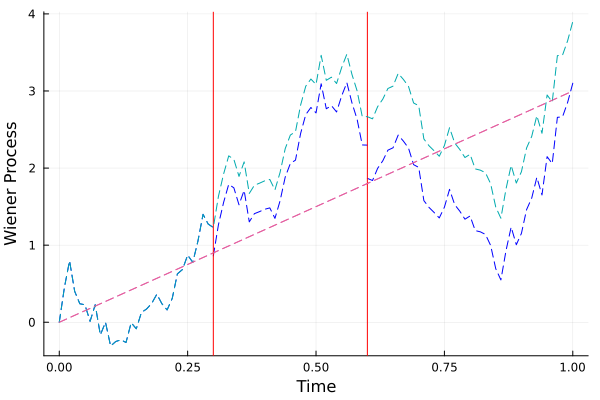

In [114]:
# Simuler le processus de Wiener avec les temps de maintenance
plot!(processARD1)
plot!(processARD1.underlying_process)

#### Fonction `observations_sampling` pour `WienerARD1`

Cette section définit une fonction `observations_sampling` qui échantillonne aléatoirement des observations à partir des valeurs du processus `WienerARD1`.

In [105]:
# function observations_sampling(ps::WienerARD1)
#     observations = Vector{Vector{Float64}}()
#     times = Vector{Vector{Float64}}()
#     for i in 1:ps.k + 1
#         indices = sort(sample(1:length(ps.values[i]), Int(round(length(ps.values[i])/4)); replace=false))
#         push!(observations, ps.values[i][indices])
#         push!(times, ps.new_times[i][indices])
#         # push!(observations, ps.values[i])
#         # push!(times, ps.new_times[i])
#     end
#     return observations, times
# end
function observations_sampling(ps::WienerARD1)
    observations = Vector{Vector{Float64}}()
    times = Vector{Vector{Float64}}()
    for i in 1:ps.k + 1
        # Generate a deterministic set of indices, e.g., every third element
        indices = collect(2:4:length(ps.values[i]))
        
        push!(observations, ps.values[i][indices])
        push!(times, ps.new_times[i][indices])
    end
    return observations, times
end


observations_sampling (generic function with 1 method)

In [113]:
observations, times = observations_sampling(processARD1)

([[0.4510069337083553, 0.22679678561606986, -0.00016861736217016476, -0.2623393968864381, 0.17200246755965354, 0.15988667351403893, 0.8715460240589679, 1.2736459983637445], [1.2660148958657997, 1.5235059837034337, 1.4353304401473927, 1.5752764145570326, 2.4493765229809155, 3.0935190880241143, 2.937434325282589, 2.299987762854103], [1.8387299498963126, 2.2633051428999464, 2.0446712887503358, 1.4238605682722678, 1.526217133320377, 1.1892632212701426, 0.6941761679954408, 1.0057354221469395, 1.8799756722707683, 2.6584841972988387]], [[0.01, 0.05, 0.09, 0.13, 0.17, 0.21, 0.25, 0.29], [0.31, 0.35, 0.39, 0.43, 0.47, 0.51, 0.55, 0.59], [0.61, 0.65, 0.69, 0.73, 0.77, 0.81, 0.85, 0.89, 0.93, 0.97]])

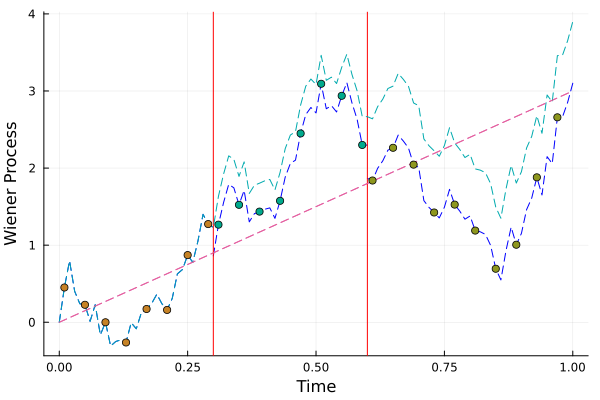

In [115]:
for i in 1:processARD1.k+1
    scatter!(times[i], observations[i])
end
plot!() 

In [47]:
processARD1.values

3-element Vector{Vector{Float64}}:
 [0.0, -0.17464641367033404, -0.18027077429555052, -0.2695694012772438, -0.36293820283380057, -0.3801860065435858, -0.46187853565309345, -0.40359488361800483, -0.3485876941784924, -0.4375112718180517  …  -0.7320470565669848, -0.6063393610827018, -0.2482386530484772, -0.1958158393217311, 0.03044733354203133, 0.27331698363701973, 0.5313064221244896, 0.3984610707027766, -0.041275766705031025, -0.16265202471923718]
 [-0.11385641730346602, -0.1339234589792555, -0.0856285869899305, -0.47383926881222815, -0.385665258089141, -0.41292445788718707, -0.3714625457085756, -0.48108486158890995, -0.5959649567144808, -0.480058762313079  …  -2.142053937151973, -2.2274155953721255, -2.2824995905869097, -2.2956119595659206, -2.444177239701507, -2.3810522297204817, -2.4297118375258484, -2.4376657749908555, -2.2876874905219085, -2.0082069622368373]
 [-1.439901798756826, -1.7909109754557684, -1.4546390924631987, -1.4896706248349036, -1.7801212440464385, -1.7320143551974407

### Implémentation des fonctions des estimateurs des paramètres `\mu`, `\sigma2` et `\rho`

In [48]:
function s(j::Int, rho::Float64, k::Int, delta_t::Vector{Vector{Float64}})
    if !(1 <= j <= k)
        exit()
    end
    
    if j > 1
        return delta_t[j + 1][1] + rho * rho * delta_t[j][1] + (1 - rho) * (1 - rho) * delta_t[j][end]
    end
    
    return delta_t[j + 1][1] + (1 - rho) * (1 - rho) * delta_t[j][end]
end

s (generic function with 1 method)

In [49]:
# Initialize Sigma matrix
function Sigma(rho::Float64, k::Int, delta_t::Vector{Vector{Float64}})
    
    S = zeros(k, k)

    # Populate Sigma using array comprehensions
    for i in 1:k
        S[i, i] = s(i, rho, k, delta_t)
    end

    for i in 1:k - 1
        S[i, i+1] = - rho * delta_t[i][1]
    end
    
    for i in 2:k
        S[i, i-1] = - rho * delta_t[i-1][1]
    end

    return S
end

Sigma (generic function with 1 method)

In [50]:
function u(j::Int, rho::Float64, k::Int, delta_t::Vector{Vector{Float64}})
    if !(1 <= j <= k)
        exit()
    end

    if j > 1
        return delta_t[j + 1][1] - rho * delta_t[j][1] + (1 - rho) * delta_t[j][end]
    end
    
    return delta_t[j + 1][1] + (1 - rho) * delta_t[j][end]
end

u (generic function with 1 method)

In [51]:
function v( j::Int, rho::Float64, k::Int, values::Vector{Vector{Float64}})
    
    diff_values = diff(values[j])
    
    if j == 1 
        diff_values = diff_values[1:end-1]  # Exclude the last element
    elseif j == k + 1
        diff_values = diff_values[2:end]
    else
        diff_values = diff_values[2:end-1]  # Exclude the first and last elements
    end
    result = rho * sum(diff_values)
    return result
end

v (generic function with 1 method)

In [52]:
v(1, rho, processARD1.k, processARD1.values)

-0.012382730011509307

In [53]:
function delta(k::Int, values::Vector{Vector{Float64}})
    differences = Vector{Vector{Float64}}()

    # Parcourir les données
    for j in 1:k + 1
        diff_values = diff(values[j])
    
        if j == 1 
            diff_values = diff_values[1:end-1]  # Exclude the last element
        elseif j == k + 1
            diff_values = diff_values[2:end]
        else
            diff_values = diff_values[2:end-1]  # Exclude the first and last elements
        end
        push!(differences, diff_values)
    end

    return differences
end


delta (generic function with 1 method)

In [54]:
function delta2(k::Int, values::Vector{Vector{Float64}})
    differences = Vector{Vector{Float64}}()

    # Parcourir les données
    for j in 1:k + 1
        push!(differences, diff(values[j]))
    end

    return differences
end


delta2 (generic function with 1 method)

In [85]:
function z(k::Int, values::Vector{Vector{Float64}})
    # Initialiser un vecteur pour stocker les différences successives
    differences = Float64[]

    # Parcourir les données
    for i in 1:k
        push!(differences, values[i + 1][1] - values[i][end])
    end

    return differences
end

println(z(processARD1.k, processARD1.values))

In [56]:
function mu_chapeau(rho::Float64, k::Int, values::Vector{Vector{Float64}}, delta_t::Vector{Vector{Float64}}) 

    # delta_t = delta(k, times)

    # Calculer l'inverse de Sigma
    Sigma_inv = inv(Sigma(rho, k, delta_t))
    
    V = [v(j, rho, k, values) for j in 1:size(Sigma_inv)[1]] #/
    
    U = [u(j, rho, k, delta_t) for j in 1:length(V)] #/
    
    Z = z(k, values)
    
    # Calculer le produit transpose(u) * Sigma_inv_v
    a = dot(U, Sigma_inv * Z)

    b = dot(U, Sigma_inv * V)
    
    c = sum(map(sum, delta(k, values)))
    
    d = dot(U, Sigma_inv * U)

    e = sum(map(sum, delta_t))

    return (a + b + c) / (d + e)
end

mu_chapeau (generic function with 1 method)

In [57]:
function sigma2_chapeau(rho::Float64, k::Int, values::Vector{Vector{Float64}}, delta_t::Vector{Vector{Float64}})

    # delta_t = delta(k, times)

    # Calculer l'inverse de Sigma
    Sigma_inv = inv(Sigma(rho, k, delta_t))
    
    V = [v(j, rho, k, values) for j in 1:size(Sigma_inv)[1]] #/
    
    U = [u(j, rho, k, delta_t) for j in 1:length(V)] #/
    
    Z = z(k, values)

    # Calculer le produit transpose(u) * Sigma_inv_v
    a = Z - mu_chapeau(rho, k, values, delta_t) .* U + V

    b = dot(a, Sigma_inv * a)
    
    diffs = delta(k, values)

    d = 0
    for (dy, dt) in zip(diffs, delta_t)
        for (dy_j, dt_j) in zip(dy, dt)
            d += ((dy_j - mu_chapeau(rho, k, values, delta_t) * dt_j)^2) / dt_j
        end
    end

    # d = sum(map(sum, (dy_j .- mu_chapeau(rho, ps))^2 for dy_j in diffs))

    N = sum(length(values[i]) for i in 1:k + 1) - 2 * k - 2
    
    return (b + d) / N
end

sigma2_chapeau (generic function with 1 method)

In [58]:
function objectif(rho::Float64, k::Int, values::Vector{Vector{Float64}}, delta_t::Vector{Vector{Float64}}, N::Int)
    try
        sigma2_hat = sigma2_chapeau(rho, k, values, delta_t)
        det_sigma = det(Sigma(rho, k, delta_t))
        
        log_sigma2_term = log(sigma2_hat)

        log_det_sigma_term = log(det_sigma)
        
        return N * log_sigma2_term / 2 + log_det_sigma_term / 2
        
    catch e
        if isa(e, DomainError) && occursin("log", string(e))
            println("Erreur : log a été appelé avec une valeur négative.")
            # Gérer l'erreur comme nécessaire, par exemple, renvoyer une valeur par défaut ou enregistrer un message d'erreur
            println("rho :", rho, "k :", k, "values", values, "delta_t", delta_t)
            return NaN
        else
            rethrow(e)
        end
    end
end


objectif (generic function with 1 method)

In [59]:
# function objectif(rho::Float64, k::Int, values::Vector{Vector{Float64}}, delta_t::Vector{Vector{Float64}}, N::Int)
#     return N * log(sigma2_chapeau(rho, k, values, delta_t)) / 2 + log(det(Sigma(rho, k, delta_t))) / 2
# end

function estimateur_rho_chapeau(k::Int, values::Vector{Vector{Float64}}, delta_t::Vector{Vector{Float64}})
    N = sum(length(values[i]) for i in 1:k + 1) - 2 * k - 2

    result = optimize(rho -> objectif(rho, k, values, delta_t, N), 0.0, 1.0)  # Minimise sur l'intervalle [0.0, 1.0]

    return Optim.minimizer(result)
end


estimateur_rho_chapeau (generic function with 1 method)

In [60]:
mu = 3.0
sigma2 = 5.0
timestep = 0.01
steps = 100
rho = 0.3
maintenance_times = [ .3 * i for i in 1:2]
estimations_rho = []
estimations_mu = []
estimations_sigma2 = []

psARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(psARD1)

observations, times = observations_sampling(psARD1)
# delta_t = delta(length(maintenance_times), psARD1.new_times)
# mu_chapeau(psARD1.rho, psARD1.k, psARD1.values, delta_t)
# sigma2_chapeau(0.5, psARD1.k, psARD1.values, delta_t)
# r = estimateur_rho_chapeau(psARD1.k, psARD1.values, delta_t)
# push!(estimations_rho, r)
# push!(estimations_mu, mu_chapeau(r, psARD1.k, observations, delta_t))
# push!(estimations_sigma2, sigma2_chapeau(r, psARD1.k, observations, delta_t))


([[0.3883627062086983, 0.552757380212239, 0.367630642952807, -0.1126125651267369, 0.10490152541113043, -0.07803984328614214, -0.04870981976349236, 0.4626378850926965], [0.8047508848731908, 1.1326851766883337, 1.457539131915895, 1.406006112942755, 1.3410320929918493, 1.0823385528415692, 1.1202853354540228, 1.3137474543981542], [1.0991336086852208, 0.22161628437737907, -0.04905721515032874, -0.11783001002798632, 0.196153330614054, 0.2789860774504685, 0.3587124254227048, -0.6774087588674205, 0.41941819153154586, 0.6863125230526326]], [[0.04, 0.06, 0.13, 0.14, 0.15, 0.16, 0.17, 0.22], [0.39, 0.42, 0.43, 0.49, 0.51, 0.56, 0.58, 0.59], [0.6, 0.68, 0.69, 0.7, 0.72, 0.73, 0.74, 0.82, 0.9, 0.91]])

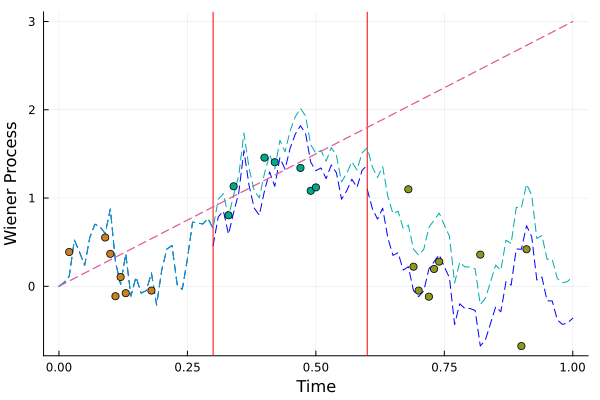

In [61]:
# Simuler le processus de Wiener avec les temps de maintenance
plot!(psARD1)
plot!(psARD1.underlying_process)
delta_t = delta2(length(maintenance_times), times)
scatter!(cumsum(delta_t[1]), observations[1])
scatter!(cumsum(delta_t[2]) .+ maintenance_times[1], observations[2])
scatter!(cumsum(delta_t[3]) .+ maintenance_times[2], observations[3])
plot!() 

In [62]:
delta_t[1]

7-element Vector{Float64}:
 0.019999999999999997
 0.07
 0.010000000000000009
 0.009999999999999981
 0.010000000000000009
 0.010000000000000009
 0.04999999999999999

In [63]:
cumsum(delta_t[1])

7-element Vector{Float64}:
 0.019999999999999997
 0.09
 0.1
 0.10999999999999999
 0.12
 0.13
 0.18

In [64]:
times[1]

8-element Vector{Float64}:
 0.04
 0.06
 0.13
 0.14
 0.15
 0.16
 0.17
 0.22

In [ ]:
observations[1]

In [107]:
mu = 3.0
sigma2 = 5.0
timestep = .01
steps = 1000
rho = 0.5
maintenance_times = [ 1. * i for i in 3:3:6]
estimations_rho = []
estimations_mu = []
estimations_sigma2 = []

psARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(psARD1)

for i in 1:100
    # Créer une instance de WienerProcess
    psARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
    simulate!(psARD1)
    observations, times = observations_sampling(psARD1)
    delta_t = delta(length(maintenance_times), psARD1.new_times)
    delta_t2 = delta2(psARD1.k, times)

    # r = estimateur_rho_chapeau(psARD1.k, psARD1.values, delta_t)
    # push!(estimations_rho, r)
    # push!(estimations_mu, mu_chapeau(r, psARD1.k, psARD1.values, delta_t))
    # push!(estimations_sigma2, sigma2_chapeau(r, psARD1.k, psARD1.values, delta_t))

    r = estimateur_rho_chapeau(psARD1.k, observations, delta_t2)
    push!(estimations_rho, r)
    push!(estimations_mu, mu_chapeau(r, psARD1.k, observations, delta_t2))
    push!(estimations_sigma2, sigma2_chapeau(r, psARD1.k, observations, delta_t2))
end

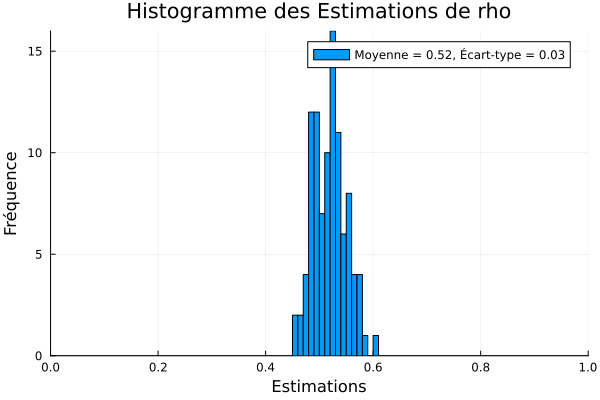

In [108]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_rho)
std_estimation = std(estimations_rho)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_rho, bins=0:0.01:1, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations de rho", xlims=(0, 1),
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()

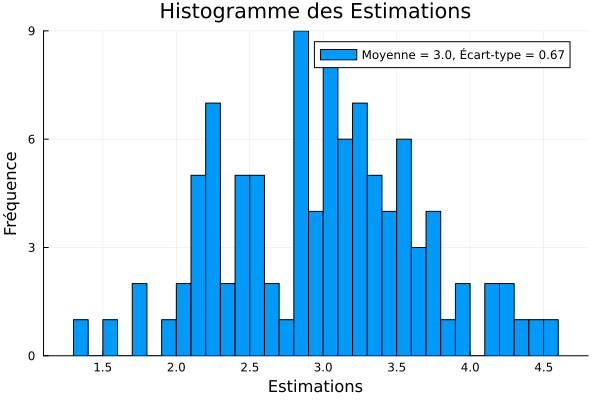

In [109]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_mu)
std_estimation = std(estimations_mu)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_mu, bins = 30, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations",
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()

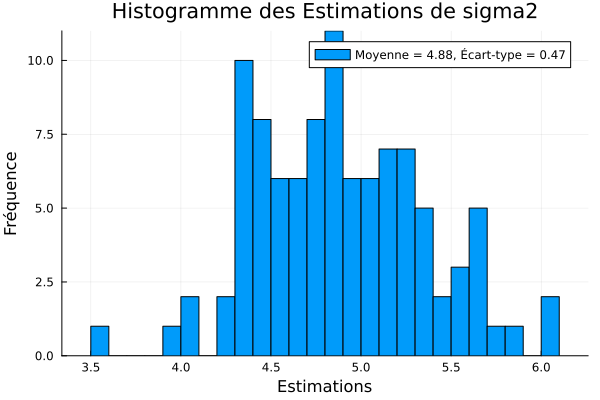

In [110]:
# Calcul de la moyenne et de l'écart-type
mean_estimation = mean(estimations_sigma2)
std_estimation = std(estimations_sigma2)

# Créer l'histogramme et ajouter la légende avec la moyenne et l'écart-type
histogram(estimations_sigma2, bins = 30, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations de sigma2",
          label="Moyenne = $(round(mean_estimation, digits=2)), Écart-type = $(round(std_estimation, digits=2))")

# Afficher le plot
plot!()

In [ ]:
estimations_sigma2

In [69]:
function vraissemblance(ps::WienerARD1, rho::Float64)
    N = sum(length(ps.values[i]) for i in 1:ps.k + 1) - 2 * ps.k - 2
    delta_t = delta(ps.k, ps.new_times)
    objectif = -(N * log(sigma2_chapeau(rho, ps.k, ps.values, delta_t)) / 2 + log(det(Sigma(rho, ps.k, delta_t))) / 2)
    return objectif
end

vraissemblance (generic function with 1 method)

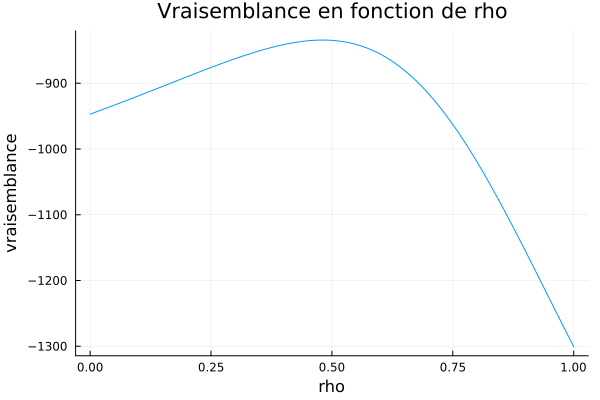

In [70]:
# Créer un vecteur de valeurs de rho entre 0 et 1
rhos = collect(0.0:0.01:1.)

# Calculer les valeurs de la fonction de vraisemblance pour chaque rho
vraisemblances = [vraissemblance(psARD1, rho) for rho in rhos]

# Tracer la fonction de vraisemblance
plot(rhos, vraisemblances, xlabel="rho", ylabel="vraisemblance", title="Vraisemblance en fonction de rho", legend = false)